In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from tbparse import SummaryReader
import pandas as pd

In [ ]:
def load_loss_weight_logs(rootdir):
    rootdir = Path(rootdir)
    rundirs = list(rootdir.glob('*lw*/'))
    if len(rundirs) == 0:
        raise ValueError(f"{rootdir} contains no loss weight logs!")
    dfs = []
    for rundir in rundirs:
        first_event_file = next(rundir.glob("*events*"))
        df = SummaryReader(str(first_event_file)).scalars
        df["Run_name"] = [rundir.name] * len(df.index)
        weights = rundir.name.split('lw')[-1].split('-')[0].split('_')[1:]
        assert len(weights) == 2
        df["CSP_weight"] = [weights[1]] * len(df.index)
        df["Mut_pos_weight"] = [weights[0]] * len(df.index)
        dfs.append(df)
    return pd.concat(dfs, axis=0)



# First, run the loss_weight_Snakefile in dasm-grid with a variety of loss weights.
df = load_loss_weight_logs('../dasm-grid/_logs')
df["Run_name"].unique()
len(df.index)

1800

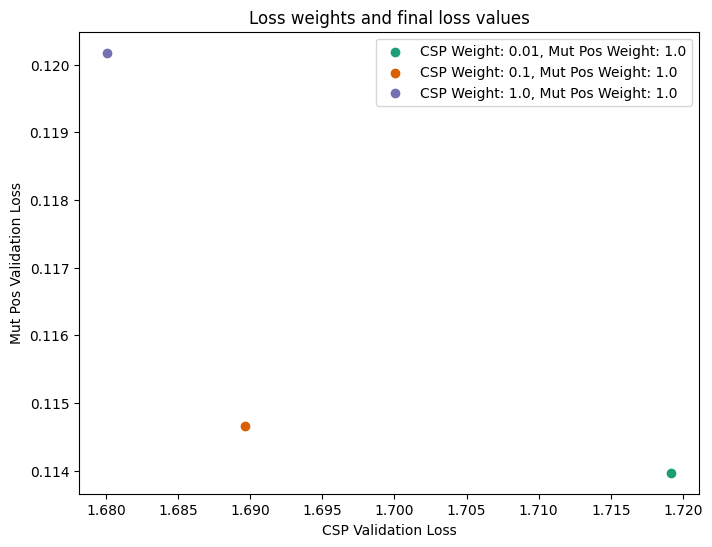

In [23]:

filtered_df = df[df['tag'].isin(['CSP_Validation_loss', 'Mut_pos_Validation_loss'])]

# Pivot to have `tag` values as columns, making calculations easier
pivot_df = filtered_df.pivot_table(index=['Run_name', 'step'], columns='tag', values='value').reset_index()

# Select the last values for each `Run_name`
last_values_df = pivot_df.sort_values('step').groupby('Run_name').last().reset_index()

# Merging weights with the last values data for labeling
last_values_df = last_values_df.merge(df[['Run_name', 'CSP_weight', 'Mut_pos_weight']].drop_duplicates(), on='Run_name')

# Setting up plot with object-oriented interface
fig, ax = plt.subplots(figsize=(8, 6))

# Define colors from Dark2 color scheme
colors = plt.cm.Dark2(range(len(last_values_df)))

# Plot each point with a unique color and add it to the legend
for i, row in last_values_df.iterrows():
    ax.scatter(
        row['CSP_Validation_loss'],
        row['Mut_pos_Validation_loss'],
        color=colors[i],
        label=f"CSP Weight: {row['CSP_weight']}, Mut Pos Weight: {row['Mut_pos_weight']}"
    )

# Label axes and title
ax.set_xlabel('CSP Validation Loss')
ax.set_ylabel('Mut Pos Validation Loss')
ax.set_title('Loss weights and final loss values')

# Display the legend with unique entries
ax.legend()